# Imports

In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax
import jax.tree_util as jtu
import jax.numpy as jnp

from functools import partial
from scipy.io import savemat

import optax


import matplotlib.pyplot as plt

from base import loss_fn, predict_fn, get_params
from utils import train_fn, latexify
from data import generate_heinonen_gp_data

jax.config.update("jax_enable_x64", True)

%reload_ext watermark

# Config

In [2]:
gen_flex_dict = {"ell": 1, "sigma": 1, "omega": 1}
model_flex_dict = {"ell": 1, "sigma": 1, "omega": 1}
method = "delta_inducing"  # "heinonen" or "delta_inducing"
latent_seed = 203
latent_key = jax.random.PRNGKey(latent_seed)
data_seed = 303
data_key = jax.random.PRNGKey(data_seed)
default_params = False

# Generate dataset

In [3]:
X_key = jax.random.PRNGKey(0)
X = jax.random.uniform(X_key, shape=(300, 1), minval=-3, maxval=3).sort(axis=0)
y, y_clean, ell, sigma, omega = generate_heinonen_gp_data(
    X, latent_key, data_key, gen_flex_dict
)

save_name = f"recover_{method}_{latent_seed}_{data_seed}_{gen_flex_dict['ell']}_{gen_flex_dict['sigma']}_{gen_flex_dict['omega']}_{model_flex_dict['ell']}_{model_flex_dict['sigma']}_{model_flex_dict['omega']}"

savemat(f"data/{save_name}.mat", {save_name: {"X": X, "y": y}})  # to run in matlab

# Normalize
# x_scaler = MinMaxScaler()
# X = x_scaler.fit_transform(X)
# xscale = x_scaler.data_max_ - x_scaler.data_min_
yscale = jnp.max(jnp.abs(y - jnp.mean(y)))
ymean = jnp.mean(y)
y = (y - ymean) / yscale

X_test = jnp.linspace(-4, 4, 400).reshape(-1, 1)

# Setup

In [4]:
value_and_grad_fn = partial(loss_fn, X=X, y=y, flex_dict=model_flex_dict, method=method)
partial_get_params = partial(
    get_params, X=X, flex_dict=model_flex_dict, method=method, default=default_params
)
params = jax.vmap(partial_get_params)(jax.random.split(jax.random.PRNGKey(1000), 10))
partial_train_fn = partial(
    train_fn, loss_fn=value_and_grad_fn, optimizer=optax.adam(0.001), n_iters=5000
)

# print("Initial loss", value_and_grad_fn(jtu.tree_map(lambda x: x[0], params)))
# sys.exit()

# Train

Losses:  [-149.69801957 -114.94823348  -82.64027755 -168.21179593  -59.27883484
 -127.70811702 -114.48192251 -157.88538473 -111.74408685 -109.13554386]


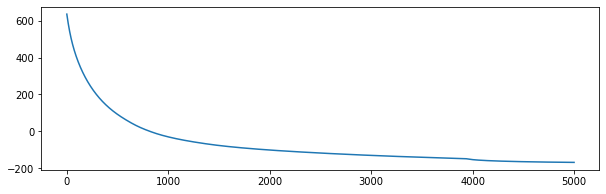

In [5]:
results = jax.vmap(partial_train_fn)(init_raw_params=params)
print("Losses: ", results["loss_history"][:, -1])
best_idx = jnp.nanargmin(results["loss_history"][:, -1])
result = jtu.tree_map(lambda x: x[best_idx], results)

# value_and_grad_fn(result["raw_params"])  # To check final loss breakdown

plt.figure(figsize=(10, 3))
plt.plot(result["loss_history"])
plt.savefig(f"figures/{save_name}_loss.png")

# Predict

In [6]:
pred_mean, pred_var, pred_ell, pred_sigma, pred_omega = predict_fn(
    result["raw_params"],
    X,
    y,
    X_test,
    model_flex_dict,
    method,
)

if method == "delta_inducing":
    X_inducing = result["raw_params"]["X_inducing"]

# Denormalize
# X = x_scaler.inverse_transform(X)
# X_test = x_scaler.inverse_transform(X_test)
# if method == "delta_inducing":
#     X_inducing = x_scaler.inverse_transform(result["raw_params"]["X_inducing"])

y = y * yscale + ymean
pred_mean = pred_mean * yscale + ymean
pred_var = pred_var * yscale**2

# pred_ell = pred_ell * xscale
pred_sigma = pred_sigma * yscale
pred_omega = pred_omega * yscale

# Plot

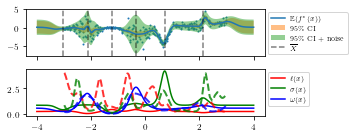

In [7]:
latexify(fig_width=5, fig_height=2)
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].scatter(X, y, s=1)
ax[0].plot(X_test, pred_mean, label=r"$\mathbb{E}(f^*(x))$")

ax[0].fill_between(
    X_test[:, 0],  # x
    pred_mean - 2 * jnp.sqrt(pred_var),  # y1
    pred_mean + 2 * jnp.sqrt(pred_var),  # y2
    alpha=0.5,
    label="95\% CI",
)
ax[0].fill_between(
    X_test[:, 0],  # x
    pred_mean - 2 * jnp.sqrt(pred_var + pred_omega**2),  # y1
    pred_mean + 2 * jnp.sqrt(pred_var + pred_omega**2),  # y2
    alpha=0.5,
    label="95\% CI + noise",
)

for i, x in enumerate(X_inducing):
    legend = "$\overline{X}$" if i == 0 else None
    ax[0].axvline(x, color="k", linestyle="--", alpha=0.5, label=legend)

ax[0].legend(bbox_to_anchor=(1, 1));

ax[1].plot(X_test, pred_ell, label=r"$\ell(x)$", color="r")
ax[1].plot(X_test, pred_sigma, label=r"$\sigma(x)$", color="g")
ax[1].plot(X_test, pred_omega, label=r"$\omega(x)$", color="b")

if "ell" in locals():
    ax[1].plot(
        X, ell, color="r", linestyle="--", alpha=0.8, linewidth=2
    )
    ax[1].plot(
        X,
        sigma,
        color="g",
        linestyle="--",
        alpha=0.8,
        linewidth=2,
    )
    ax[1].plot(
        X,
        omega,
        color="b",
        linestyle="--",
        alpha=0.8,
        linewidth=2,
    )

ax[1].legend(bbox_to_anchor=(1, 1));
fig.tight_layout()
fig.savefig(f"figures/{save_name}.pdf");

In [8]:
%watermark --iversion

matplotlib: 3.5.1
jax       : 0.3.25
sys       : 3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0]
optax     : 0.1.3



# End

A reasonable data for AL: 
* 203, 303
* 206, 306
